# Explore neural network model using [TensorFlow](https://www.tensorflow.org/) library
[PyTorch](https://pytorch.org/) is another good alternative 

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap, os, shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve

In [105]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping

import tensorflow as tf

## Load leaf absorbance data

In [3]:
data = pd.read_excel('3011979_datasets.xlsx', sheet_name = 'leaf_absorbance', index_col = None)
data = data.loc[~pd.isna(data).any(axis = 1)]
data.head()

,ConditionID,CultivarID,Pi,324,334,344,354,364,374,384,...,694,704,714,724,734,744,754,764,774,784
0,1,1,86.223677,0.136531,0.077077,0.075083,0.061408,0.058935,0.054756,0.055509,...,0.129893,0.218741,0.304643,0.374003,0.414906,0.438958,0.445656,0.444957,0.447571,0.442941
1,1,1,104.792925,0.128571,0.092857,0.084086,0.055360,0.069373,0.050320,0.048282,...,0.117621,0.202819,0.291199,0.366811,0.410271,0.439536,0.443814,0.444727,0.444642,0.446600
2,1,1,167.335884,0.094961,0.128649,0.123823,0.066028,0.054652,0.049103,0.044307,...,0.136578,0.229855,0.320378,0.397110,0.440710,0.464248,0.473719,0.471862,0.472635,0.471684
3,1,1,215.911286,0.130802,0.087640,0.102281,0.085255,0.074521,0.064555,0.057626,...,0.138065,0.228084,0.316342,0.389543,0.429343,0.454860,0.458740,0.458078,0.461857,0.463952
4,1,1,223.691091,0.125862,0.089796,0.075459,0.095190,0.061393,0.070902,0.061411,...,0.131028,0.219312,0.309854,0.385228,0.429559,0.457268,0.462188,0.463328,0.463395,0.466131


In [4]:
condition_label = data['ConditionID']
input_data = data.iloc[:, 3:]

print('input data shape:', input_data.shape)

input data shape: (3094, 47)


In [119]:
print(np.unique(condition_label))

[1 2 3]


## Convert label to onehot representation

In [120]:
label = OneHotEncoder(sparse = False).fit_transform(condition_label.values.reshape([-1, 1]))

In [121]:
label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Withhold 20% as test and 20% as validation
Also standardize everything

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(input_data, label, test_size = 0.2,
                                                          stratify = condition_label, random_state = 3011979)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25,
                                                  stratify = condition_label.loc[X_trainval.index], random_state = 3011979)

X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_val_std = pd.DataFrame(X_scaler.transform(X_val), index = X_val.index, columns = X_val.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

print('training size:', X_train.shape[0])
print('validation size:', X_val.shape[0])
print('test size:', X_test.shape[0])

training size: 1856
validation size: 619
test size: 619


## Define a fully-connected network with one hidden layer

In [7]:
def generate_model(n_hidden):
    inputs1 = Input(shape = (X_train_std.shape[1],))
    x = Dense(units = n_hidden, activation = 'relu')(inputs1)
    
    inputs2 = Input(shape = (X_train_std.shape[1],))
    y = Dense(units = n_hidden, activation = 'relu')(inputs2)
    
    z = Concatenate()([x, y])
    
    outputs = Dense(units = 3, activation = 'softmax')(z)

    return Model(inputs = [inputs1, inputs2], outputs = outputs)

## Define checkpoint

In [8]:
modelckpt = ModelCheckpoint('./L14_onelayer_rice', verbose = 1, save_best_only = True, save_weights_only = False)
tensorboard = TensorBoard('./L14_onelayer_rice_tb', histogram_freq = 1)
reduced_lr = ReduceLROnPlateau(patience = 5, factor = 0.2)
early_stop = EarlyStopping(patience = 20, restore_best_weights = True)

## Initiate TensorBoard

In [9]:
%load_ext tensorboard

In [11]:
%tensorboard --logdir=./L14_onelayer_rice_tb --host localhost

## Train model for 20 epochs

In [12]:
model = generate_model(64)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1e-4))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47)]              0         
                                                                 
 dense (Dense)               (None, 64)                3072      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,267
Trainable params: 3,267
Non-trainable params: 0
_________________________________________________________________


In [13]:
tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 20,
                    callbacks = [modelckpt, tensorboard, reduced_lr, early_stop], verbose = 1, shuffle = True)

Epoch 1/20
 1/29 [>.............................] - ETA: 19s - loss: 1.4041
Epoch 00001: val_loss improved from inf to 1.23050, saving model to .\L14_onelayer_rice
29/29 [==============================] - 2s 32ms/step - loss: 1.3191 - val_loss: 1.2305 - lr: 1.0000e-04
Epoch 2/20
 1/29 [>.............................] - ETA: 0s - loss: 1.2564
Epoch 00002: val_loss improved from 1.23050 to 1.11539, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 26ms/step - loss: 1.1810 - val_loss: 1.1154 - lr: 1.0000e-04
Epoch 3/20
 1/29 [>.............................] - ETA: 0s - loss: 1.1102
Epoch 00003: val_loss improved from 1.11539 to 1.03968, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 25ms/step - loss: 1.0879 - val_loss: 1.0397 - lr: 1.0000e-04
Epoch 4/20
 1/29 [>.............................] - ETA: 0s - loss: 1.0383
Epoch 00004: val_loss improved from 1.03968 to 0.98656, saving model to .\L14_onelayer_rice
29/29 [=============

## View loss trend

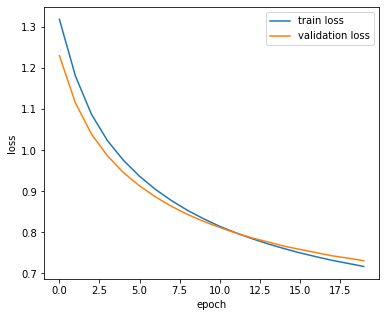

In [15]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

## Train for 20 more epochs since the model hasn't converged yet

In [16]:
tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 20,
                    callbacks = [modelckpt, tensorboard, reduced_lr, early_stop], verbose = 1, shuffle = True)

Epoch 1/20
 1/29 [>.............................] - ETA: 4s - loss: 0.8150
Epoch 00001: val_loss improved from 0.73110 to 0.72584, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 28ms/step - loss: 0.7105 - val_loss: 0.7258 - lr: 1.0000e-04
Epoch 2/20
 1/29 [>.............................] - ETA: 0s - loss: 0.7473
Epoch 00002: val_loss improved from 0.72584 to 0.72042, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 28ms/step - loss: 0.7044 - val_loss: 0.7204 - lr: 1.0000e-04
Epoch 3/20
 1/29 [>.............................] - ETA: 0s - loss: 0.7222
Epoch 00003: val_loss improved from 0.72042 to 0.71620, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 22ms/step - loss: 0.6982 - val_loss: 0.7162 - lr: 1.0000e-04
Epoch 4/20
 1/29 [>.............................] - ETA: 0s - loss: 0.7750
Epoch 00004: val_loss improved from 0.71620 to 0.71218, saving model to .\L14_onelayer_rice
29/29 [==========

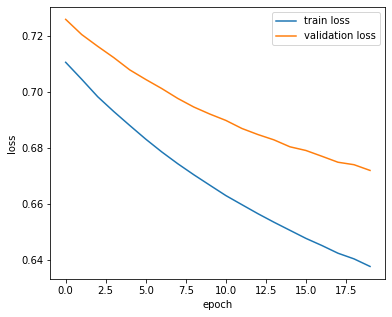

In [17]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

## The model still shows no sign of converging - we might want to increase learning rate

In [18]:
model.optimizer.learning_rate.assign(5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0005>

In [19]:
tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 50,
                    callbacks = [modelckpt, tensorboard, reduced_lr, early_stop], verbose = 1, shuffle = True)

Epoch 1/50
 1/29 [>.............................] - ETA: 4s - loss: 0.7475
Epoch 00001: val_loss improved from 0.67184 to 0.66693, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 39ms/step - loss: 0.6338 - val_loss: 0.6669 - lr: 5.0000e-04
Epoch 2/50
 1/29 [>.............................] - ETA: 0s - loss: 0.6762
Epoch 00002: val_loss improved from 0.66693 to 0.65952, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 26ms/step - loss: 0.6247 - val_loss: 0.6595 - lr: 5.0000e-04
Epoch 3/50
 1/29 [>.............................] - ETA: 0s - loss: 0.6654
Epoch 00003: val_loss improved from 0.65952 to 0.65389, saving model to .\L14_onelayer_rice
29/29 [==============================] - 1s 26ms/step - loss: 0.6159 - val_loss: 0.6539 - lr: 5.0000e-04
Epoch 4/50
 1/29 [>.............................] - ETA: 0s - loss: 0.7080
Epoch 00004: val_loss improved from 0.65389 to 0.65130, saving model to .\L14_onelayer_rice
29/29 [==========

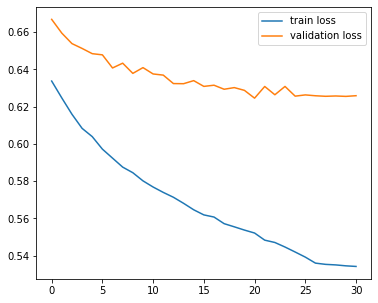

In [20]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

## Examine the model performance

In [21]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_test_std), axis = 1)))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       237
           1       0.55      0.55      0.55       210
           2       0.85      0.88      0.87       172

    accuracy                           0.67       619
   macro avg       0.68      0.68      0.68       619
weighted avg       0.67      0.67      0.67       619



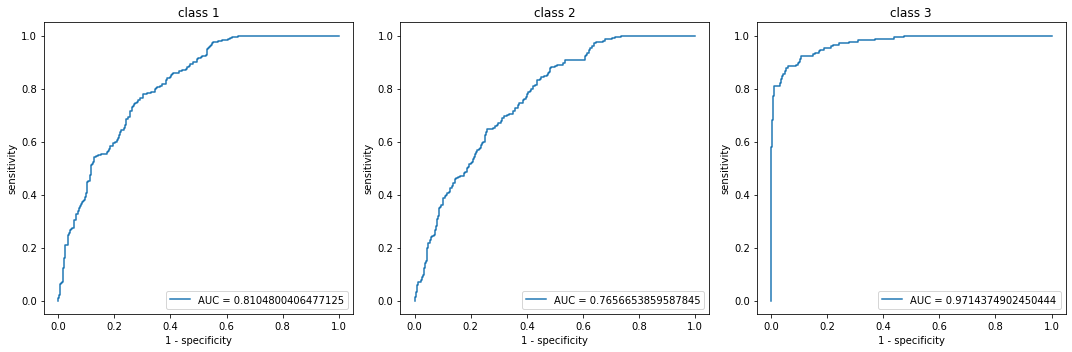

In [22]:
y_predict = model.predict(X_test_std)

plt.figure(figsize = (15, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_predict[:, i])
    plt.plot(fpr, tpr, label = 'AUC = ' + str(roc_auc_score(y_test[:, i], y_predict[:, i])))
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')

plt.tight_layout()
plt.show()

## Let's tune the number of hidden neuron
* Try powers of 2: 32, 64, 128, 256, 512
* Make sure to turn verbose off (vebose = 0) if you don't want to see logs
* Set learning rate to 5e-4
* Use only reduced learning rate and early stopping checkpoints
* Save predictions

In [25]:
y_predicts = {} 

for n_hidden in [32, 64, 128, 256, 512]:
    tf.random.set_seed(3011979)
    model = generate_model(n_hidden)
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 5e-4))
    model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 20,
              callbacks = [reduced_lr, early_stop], verbose = 0, shuffle = True)
    
    y_predicts[n_hidden] = model.predict(X_test_std)

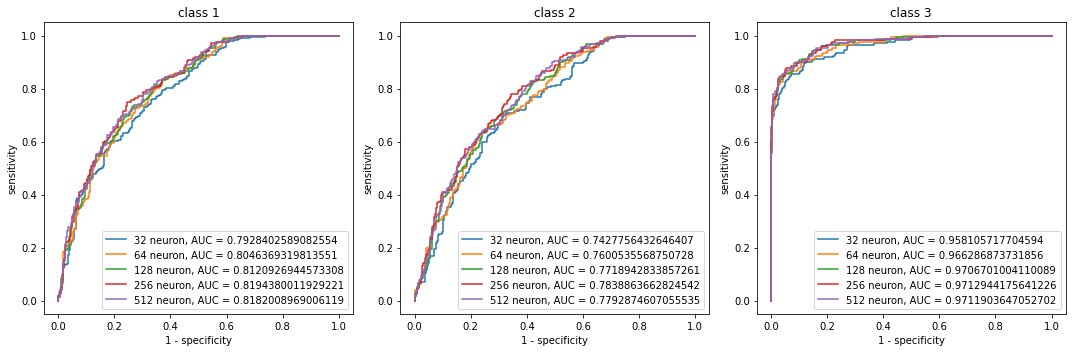

In [26]:
plt.figure(figsize = (15, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    
    for n_hidden in y_predicts:
        fpr, tpr, thresholds = roc_curve(y_test[:, i], y_predicts[n_hidden][:, i])
        plt.plot(fpr, tpr, label = str(n_hidden) + ' neuron, AUC = ' + str(roc_auc_score(y_test[:, i], y_predicts[n_hidden][:, i])))
    
    plt.title('class ' + str(i + 1))
    plt.legend(loc = 'lower right')
    plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')

plt.tight_layout()
plt.show()

## Let's try using multiple layers

In [122]:
def generate_multilayer_model(n_hiddens):
    if len(n_hiddens) == 1:
        return generate_model(n_hiddens[0])
    
    inputs = Input(shape = (X_train_std.shape[1],))
    x = Dense(units = n_hiddens[0], activation = 'relu')(inputs)
    
    for n in n_hiddens[1:]:
        x = Dense(units = n, activation = 'relu')(x)

    outputs = Dense(units = 3, activation = 'softmax')(x)

    return Model(inputs = inputs, outputs = outputs)

In [123]:
dummy_model = generate_multilayer_model([256, 32])
dummy_model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_80 (Dense)            (None, 256)               200960    
                                                                 
 dense_81 (Dense)            (None, 32)                8224      
                                                                 
 dense_82 (Dense)            (None, 3)                 99        
                                                                 
Total params: 209,283
Trainable params: 209,283
Non-trainable params: 0
_________________________________________________________________


In [47]:
model = generate_multilayer_model([256, 32])
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 5e-4),
              metrics = [tf.keras.metrics.AUC(), 'accuracy'])

tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 50,
                    callbacks = [reduced_lr, early_stop], verbose = 1, shuffle = True)

Train on 1856 samples, validate on 619 samples
Epoch 1/50
1856/1856 [==============================] - 0s 97us/sample - loss: 0.9052 - auc_4: 0.7627 - acc: 0.5544 - val_loss: 0.7567 - val_auc_4: 0.8486 - val_acc: 0.6397 - lr: 5.0000e-04
Epoch 2/50
1856/1856 [==============================] - 0s 23us/sample - loss: 0.6961 - auc_4: 0.8676 - acc: 0.6778 - val_loss: 0.6826 - val_auc_4: 0.8639 - val_acc: 0.6656 - lr: 5.0000e-04
Epoch 3/50
1856/1856 [==============================] - 0s 22us/sample - loss: 0.6400 - auc_4: 0.8807 - acc: 0.6875 - val_loss: 0.6684 - val_auc_4: 0.8644 - val_acc: 0.6704 - lr: 5.0000e-04
Epoch 4/50
1856/1856 [==============================] - 0s 24us/sample - loss: 0.6089 - auc_4: 0.8913 - acc: 0.7144 - val_loss: 0.6457 - val_auc_4: 0.8733 - val_acc: 0.6882 - lr: 5.0000e-04
Epoch 5/50
1856/1856 [==============================] - 0s 23us/sample - loss: 0.5894 - auc_4: 0.8971 - acc: 0.7112 - val_loss: 0.6385 - val_auc_4: 0.8736 - val_acc: 0.6801 - lr: 5.0000e-04
Epo

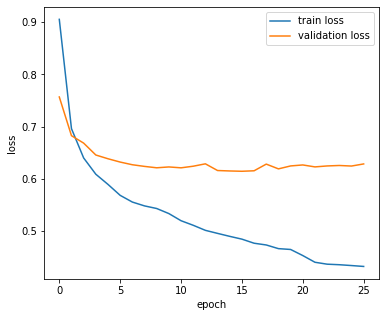

In [48]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

## We should slow down learning rate here

In [49]:
model = generate_multilayer_model([256, 32])
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1e-4),
              metrics = [tf.keras.metrics.AUC(), 'accuracy'])

tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 50,
                    callbacks = [reduced_lr, early_stop], verbose = 1, shuffle = True)

Train on 1856 samples, validate on 619 samples
Epoch 1/50
1856/1856 [==============================] - 0s 120us/sample - loss: 0.9895 - auc_5: 0.7221 - acc: 0.5216 - val_loss: 0.9133 - val_auc_5: 0.7927 - val_acc: 0.5703 - lr: 1.0000e-04
Epoch 2/50
1856/1856 [==============================] - 0s 27us/sample - loss: 0.8675 - auc_5: 0.8161 - acc: 0.6121 - val_loss: 0.8388 - val_auc_5: 0.8217 - val_acc: 0.6090 - lr: 1.0000e-04
Epoch 3/50
1856/1856 [==============================] - 0s 27us/sample - loss: 0.8036 - auc_5: 0.8396 - acc: 0.6369 - val_loss: 0.7931 - val_auc_5: 0.8401 - val_acc: 0.6365 - lr: 1.0000e-04
Epoch 4/50
1856/1856 [==============================] - 0s 24us/sample - loss: 0.7595 - auc_5: 0.8554 - acc: 0.6503 - val_loss: 0.7598 - val_auc_5: 0.8496 - val_acc: 0.6559 - lr: 1.0000e-04
Epoch 5/50
1856/1856 [==============================] - 0s 28us/sample - loss: 0.7267 - auc_5: 0.8631 - acc: 0.6643 - val_loss: 0.7347 - val_auc_5: 0.8556 - val_acc: 0.6704 - lr: 1.0000e-04
Ep

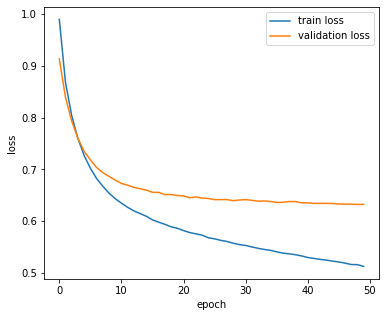

In [50]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

## Model overfit quite quickly - Let's try adding a [dropout](https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png) layer

In [57]:
def generate_multilayer_model_with_dropout(n_hiddens, dropout_rate):
    if len(n_hiddens) == 1:
        return generate_model(n_hiddens[0])
    
    inputs = Input(shape = (X_train_std.shape[1],))
    x = Dense(units = n_hiddens[0], activation = 'relu')(inputs)
    
    for n in n_hiddens[1:]:
        x = Dropout(dropout_rate)(x)
        x = Dense(units = n, activation = 'relu')(x)

    outputs = Dense(units = 3, activation = 'softmax')(x)

    return Model(inputs = inputs, outputs = outputs)

In [63]:
model = generate_multilayer_model_with_dropout([256, 32], 0.4)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 5e-5),
              metrics = [tf.keras.metrics.AUC(), 'accuracy'])

tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 100,
                    callbacks = [reduced_lr, early_stop], verbose = 1, shuffle = True)

Train on 1856 samples, validate on 619 samples
Epoch 1/100
1856/1856 [==============================] - 0s 203us/sample - loss: 1.1044 - auc_14: 0.5576 - acc: 0.3648 - val_loss: 1.0210 - val_auc_14: 0.6714 - val_acc: 0.5073 - lr: 5.0000e-05
Epoch 2/100
1856/1856 [==============================] - 0s 32us/sample - loss: 1.0347 - auc_14: 0.6455 - acc: 0.4564 - val_loss: 0.9514 - val_auc_14: 0.7554 - val_acc: 0.5670 - lr: 5.0000e-05
Epoch 3/100
1856/1856 [==============================] - 0s 32us/sample - loss: 0.9697 - auc_14: 0.7102 - acc: 0.5178 - val_loss: 0.9059 - val_auc_14: 0.7845 - val_acc: 0.5687 - lr: 5.0000e-05
Epoch 4/100
1856/1856 [==============================] - 0s 33us/sample - loss: 0.9317 - auc_14: 0.7435 - acc: 0.5329 - val_loss: 0.8739 - val_auc_14: 0.7986 - val_acc: 0.5654 - lr: 5.0000e-05
Epoch 5/100
1856/1856 [==============================] - 0s 30us/sample - loss: 0.8895 - auc_14: 0.7738 - acc: 0.5663 - val_loss: 0.8485 - val_auc_14: 0.8104 - val_acc: 0.5703 - lr

1856/1856 [==============================] - 0s 27us/sample - loss: 0.6302 - auc_14: 0.8826 - acc: 0.6950 - val_loss: 0.6540 - val_auc_14: 0.8685 - val_acc: 0.6640 - lr: 5.0000e-05
Epoch 44/100
1856/1856 [==============================] - 0s 28us/sample - loss: 0.6180 - auc_14: 0.8869 - acc: 0.7020 - val_loss: 0.6519 - val_auc_14: 0.8695 - val_acc: 0.6688 - lr: 5.0000e-05
Epoch 45/100
1856/1856 [==============================] - 0s 26us/sample - loss: 0.6299 - auc_14: 0.8794 - acc: 0.6848 - val_loss: 0.6497 - val_auc_14: 0.8702 - val_acc: 0.6656 - lr: 5.0000e-05
Epoch 46/100
1856/1856 [==============================] - 0s 28us/sample - loss: 0.6213 - auc_14: 0.8856 - acc: 0.6967 - val_loss: 0.6489 - val_auc_14: 0.8705 - val_acc: 0.6672 - lr: 5.0000e-05
Epoch 47/100
1856/1856 [==============================] - 0s 29us/sample - loss: 0.6373 - auc_14: 0.8787 - acc: 0.6837 - val_loss: 0.6486 - val_auc_14: 0.8705 - val_acc: 0.6672 - lr: 5.0000e-05
Epoch 48/100
1856/1856 [===================

1856/1856 [==============================] - 0s 26us/sample - loss: 0.5801 - auc_14: 0.8988 - acc: 0.7193 - val_loss: 0.6323 - val_auc_14: 0.8756 - val_acc: 0.6753 - lr: 5.0000e-05
Epoch 86/100
1856/1856 [==============================] - 0s 29us/sample - loss: 0.5808 - auc_14: 0.8994 - acc: 0.7117 - val_loss: 0.6315 - val_auc_14: 0.8761 - val_acc: 0.6866 - lr: 5.0000e-05
Epoch 87/100
1856/1856 [==============================] - 0s 27us/sample - loss: 0.5837 - auc_14: 0.8963 - acc: 0.7031 - val_loss: 0.6302 - val_auc_14: 0.8765 - val_acc: 0.6834 - lr: 5.0000e-05
Epoch 88/100
1856/1856 [==============================] - 0s 26us/sample - loss: 0.5827 - auc_14: 0.8984 - acc: 0.7177 - val_loss: 0.6317 - val_auc_14: 0.8759 - val_acc: 0.6817 - lr: 5.0000e-05
Epoch 89/100
1856/1856 [==============================] - 0s 27us/sample - loss: 0.5807 - auc_14: 0.8995 - acc: 0.7209 - val_loss: 0.6307 - val_auc_14: 0.8764 - val_acc: 0.6850 - lr: 5.0000e-05
Epoch 90/100
1856/1856 [===================

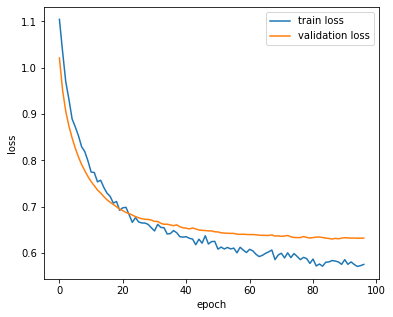

In [64]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

## Examine model performance

In [65]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_test_std), axis = 1)))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       237
           1       0.56      0.50      0.53       210
           2       0.84      0.87      0.85       172

    accuracy                           0.66       619
   macro avg       0.67      0.67      0.67       619
weighted avg       0.66      0.66      0.66       619



`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


## The single-layer model with 256 hidden neurons performs best

## For another example, we will explore [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset

In [80]:
data = pd.read_csv('L11.2_mnist_fashion.csv', header = 0, index_col = False)
data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


## Extract label and input portions

In [81]:
mnist_label = data['label']
input_data = data.iloc[:, 1:]

print('input data shape:', input_data.shape)

input data shape: (60000, 784)


In [124]:
label = OneHotEncoder(sparse = False).fit_transform(mnist_label.values.reshape([-1, 1]))
print('number of classes:', len(np.unique(mnist_label)))

number of classes: 10


In [125]:
label

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Split data into 60:20:20 portion

In [126]:
X_trainval, X_test, y_trainval, y_test = train_test_split(input_data, label, test_size = 0.2,
                                                          stratify = mnist_label, random_state = 3011979)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25,
                                                  stratify = mnist_label.loc[X_trainval.index], random_state = 3011979)

X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)
X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_val_std = pd.DataFrame(X_scaler.transform(X_val), index = X_val.index, columns = X_val.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

print('training size:', X_train.shape[0])
print('validation size:', X_val.shape[0])
print('test size:', X_test.shape[0])

training size: 36000
validation size: 12000
test size: 12000


## Let's train a fully-connected model
Change the number of output head from 3 to 10

In [127]:
def generate_model_mnist(n_hidden):
    inputs = Input(shape = (X_train_std.shape[1],))
    x = Dense(units = n_hidden, activation = 'relu')(inputs)
    outputs = Dense(units = 10, activation = 'softmax')(x)

    return Model(inputs = inputs, outputs = outputs)

In [132]:
model = generate_model_mnist(1024)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 5e-5))

tf.random.set_seed(3011979)
history = model.fit(X_train_std.values, y_train, batch_size = 64, validation_data = (X_val_std.values, y_val), epochs = 50,
                    callbacks = [reduced_lr, early_stop], verbose = 1, shuffle = True)

Train on 36000 samples, validate on 12000 samples
Epoch 1/50
36000/36000 [==============================] - 5s 143us/sample - loss: 0.6054 - val_loss: 0.4535 - lr: 5.0000e-05
Epoch 2/50
36000/36000 [==============================] - 4s 115us/sample - loss: 0.3989 - val_loss: 0.4051 - lr: 5.0000e-05
Epoch 3/50
36000/36000 [==============================] - 4s 115us/sample - loss: 0.3519 - val_loss: 0.3824 - lr: 5.0000e-05
Epoch 4/50
36000/36000 [==============================] - 4s 116us/sample - loss: 0.3221 - val_loss: 0.3715 - lr: 5.0000e-05
Epoch 5/50
36000/36000 [==============================] - 4s 118us/sample - loss: 0.2996 - val_loss: 0.3574 - lr: 5.0000e-05
Epoch 6/50
36000/36000 [==============================] - 4s 121us/sample - loss: 0.2825 - val_loss: 0.3515 - lr: 5.0000e-05
Epoch 7/50
36000/36000 [==============================] - 4s 116us/sample - loss: 0.2673 - val_loss: 0.3456 - lr: 5.0000e-05
Epoch 8/50
36000/36000 [==============================] - 4s 115us/sample -

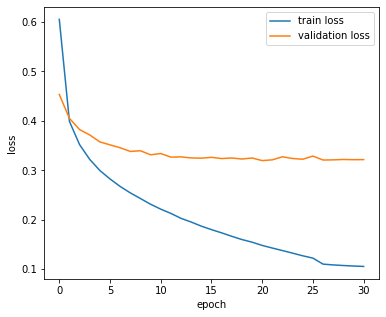

In [133]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

In [134]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_test_std), axis = 1)))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1200
           1       0.99      0.98      0.98      1200
           2       0.84      0.81      0.82      1200
           3       0.88      0.89      0.89      1200
           4       0.80      0.83      0.82      1200
           5       0.95      0.95      0.95      1200
           6       0.73      0.68      0.70      1200
           7       0.94      0.95      0.95      1200
           8       0.96      0.96      0.96      1200
           9       0.97      0.95      0.96      1200

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000



## These data are actually image - Transform 784 x 1 to 28 x 28

In [94]:
reshaped_data = []

for i in range(input_data.shape[0]):
    reshaped_data.append(np.reshape(input_data.iloc[i, :].to_numpy(), (28, 28, 1)))

reshaped_data = np.array(reshaped_data)
print('shape of new input data:', reshaped_data.shape)

shape of new input data: (60000, 28, 28, 1)


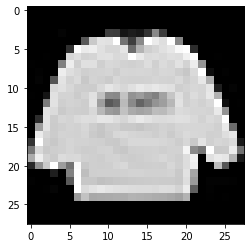

In [96]:
plt.imshow(reshaped_data[0, :], cmap = 'gray')

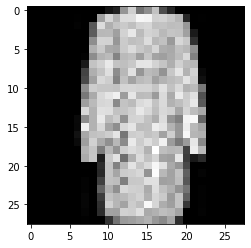

In [98]:
plt.imshow(reshaped_data[200, :], cmap = 'gray')

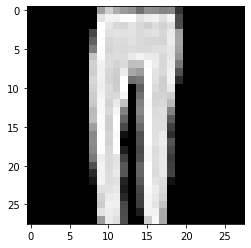

In [136]:
plt.imshow(reshaped_data[16000, :], cmap = 'gray')

## Split the reshaped data and scale gray value from 0-255 to 0-1

In [101]:
X_reshaped_train = reshaped_data[[i for i in range(input_data.shape[0]) if input_data.index[i] in X_train.index], :]
X_reshaped_val = reshaped_data[[i for i in range(input_data.shape[0]) if input_data.index[i] in X_val.index], :]
X_reshaped_test = reshaped_data[[i for i in range(input_data.shape[0]) if input_data.index[i] in X_test.index], :]

X_reshaped_train = X_reshaped_train / 255.0
X_reshaped_val = X_reshaped_val / 255.0
X_reshaped_test = X_reshaped_test / 255.0

print('training size:', X_reshaped_train.shape[0])
print('validation size:', X_reshaped_val.shape[0])
print('test size:', X_reshaped_test.shape[0])

training size: 36000
validation size: 12000
test size: 12000


## Define a basic CNN model
Sequential() is another way to construct model with no branch

In [137]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = [5, 5], padding = 'valid', strides = [2, 2], 
                 activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 128, kernel_size = [3, 3], padding = 'valid', strides = [1, 1], activation = 'relu'))
model.add(MaxPooling2D(pool_size = [3, 3], strides = [2, 2]))
model.add(Conv2D(filters = 256, kernel_size = [3, 3], padding = 'same', strides = [1, 1], activation = 'relu'))
model.add(MaxPooling2D(pool_size = [3, 3], strides = [2, 2]))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

In [138]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)              

In [140]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 1e-3))

tf.random.set_seed(3011979)
history = model.fit(X_reshaped_train, y_train, batch_size = 256, validation_data = (X_reshaped_val, y_val), 
                    epochs = 50, callbacks = [reduced_lr, early_stop], verbose = 1, shuffle = True)

Train on 36000 samples, validate on 12000 samples
Epoch 1/50
36000/36000 [==============================] - 17s 477us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 2/50
36000/36000 [==============================] - 16s 448us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 3/50
36000/36000 [==============================] - 16s 446us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 4/50
36000/36000 [==============================] - 16s 443us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 5/50
36000/36000 [==============================] - 16s 452us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 6/50
36000/36000 [==============================] - 17s 459us/sample - loss: 2.3027 - val_loss: 2.3026 - lr: 0.0010
Epoch 7/50
36000/36000 [==============================] - 16s 447us/sample - loss: 2.3026 - val_loss: 2.3026 - lr: 2.0000e-04
Epoch 8/50
36000/36000 [==============================] - 16s 448us/sample - loss: 2.3026 - 

KeyboardInterrupt: 

In [112]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_reshaped_test), axis = 1)))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


              precision    recall  f1-score   support

           0       0.14      0.01      0.02      1200
           1       0.00      0.00      0.00      1200
           2       0.10      0.99      0.18      1200
           3       0.00      0.00      0.00      1200
           4       0.16      0.01      0.01      1200
           5       0.00      0.00      0.00      1200
           6       0.00      0.00      0.00      1200
           7       0.00      0.00      0.00      1200
           8       0.00      0.00      0.00      1200
           9       0.00      0.00      0.00      1200

    accuracy                           0.10     12000
   macro avg       0.04      0.10      0.02     12000
weighted avg       0.04      0.10      0.02     12000



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
